In [7]:
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# dataset import
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ML
data = pd.read_csv('abalone_data.csv', names=['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Rings'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ML


# Exploratory Data Analysis and Preprocessing

In [3]:
# details about the data
print(data)
data.info()
data.describe()

     Sex  Length  Diameter  ...  Viscera_weight  Shell_weight  Rings
0      M   0.455     0.365  ...          0.1010        0.1500     15
1      M   0.350     0.265  ...          0.0485        0.0700      7
2      F   0.530     0.420  ...          0.1415        0.2100      9
3      M   0.440     0.365  ...          0.1140        0.1550     10
4      I   0.330     0.255  ...          0.0395        0.0550      7
...   ..     ...       ...  ...             ...           ...    ...
4172   F   0.565     0.450  ...          0.2390        0.2490     11
4173   M   0.590     0.440  ...          0.2145        0.2605     10
4174   M   0.600     0.475  ...          0.2875        0.3080      9
4175   F   0.625     0.485  ...          0.2610        0.2960     10
4176   M   0.710     0.555  ...          0.3765        0.4950     12

[4177 rows x 9 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtyp

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


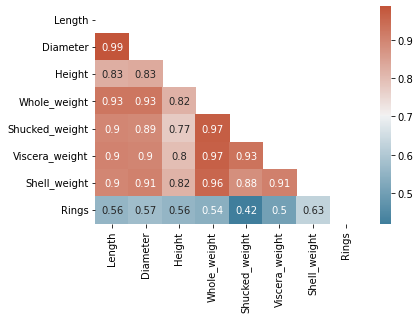

In [4]:
# heatmap to understand the correlation between features
corr = data.corr()
f, ax = plt.subplots()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efe195f0510>,
      dtype=object)

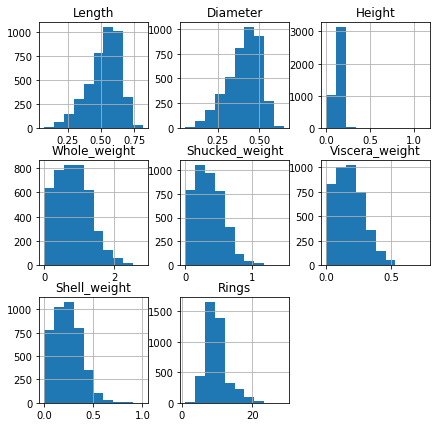

In [8]:
data.hist(figsize=(7, 7))

In [9]:
# pre-processing to convert Sex column values {'I', 'M', 'F'} to integers {0, 1, 2}
convert = {'Sex': {'I':0, 'M':1, 'F':2}}
data = data.replace(convert)

# dropping the highly correlated features
data = data.drop(['Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Diameter'], axis = 1)

print(data)

      Sex  Length  Height  Whole_weight  Rings
0       1   0.455   0.095        0.5140     15
1       1   0.350   0.090        0.2255      7
2       2   0.530   0.135        0.6770      9
3       1   0.440   0.125        0.5160     10
4       0   0.330   0.080        0.2050      7
...   ...     ...     ...           ...    ...
4172    2   0.565   0.165        0.8870     11
4173    1   0.590   0.135        0.9660     10
4174    1   0.600   0.205        1.1760      9
4175    2   0.625   0.150        1.0945     10
4176    1   0.710   0.195        1.9485     12

[4177 rows x 5 columns]


# Dataset Split and Standardisation

In [10]:
# splitting data into test and train datasets
def split_train_test(input, output, train_ratio=0.8):
    X_train = []
    Y_train = []
    X_test = input.tolist()
    Y_test = output.tolist()
    train_size = math.floor(train_ratio * len(input))
    
    while len(X_train) < train_size:
      index = random.randint(0, len(X_test)-1)
      X_train.append(X_test.pop(index))
      Y_train.append(Y_test.pop(index))
    
    return X_train, X_test, Y_train, Y_test

# standardisation of the input features
def standardise(data):
  for i in range(data.shape[1] - 1):
    data[:][i] = ((data[:][i] - np.mean(data[:][i]))/np.std(data[:][i]))
  return data

# separating input and output features
output = data['Rings']
input = data.drop('Rings', axis='columns')

# inserting bias row in input
newrow = np.ones(np.shape(input)[0])
input.insert(0, "x0", newrow, True)

input = input.to_numpy()
output = output.to_numpy()

# splitting data into test and train datasets
random.seed(0)
X_train, X_test, Y_train, Y_test = split_train_test(input, output, 0.8)

X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

Y_train = np.reshape(Y_train, (Y_train.shape[0], 1))
Y_test = np.reshape(Y_test, (Y_test.shape[0], 1))

#standardising the data	
X_train = standardise(X_train)
Y_train = standardise(Y_train)

# Training and Testing

RMSE on Training data:
2.631090269245726


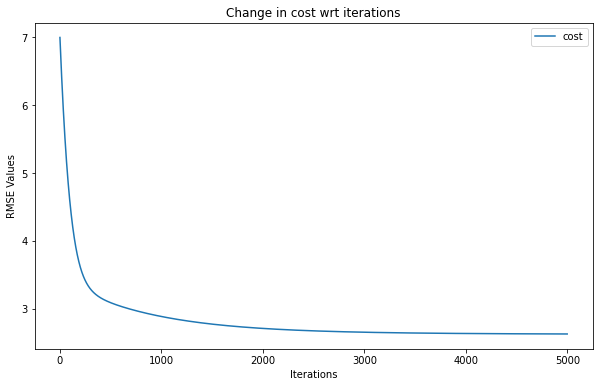

In [24]:
h_theta_vec = []
theta_vec = []
cost_vec = []

# calculation of hypothesis 
def hypothesis(theta, x):
    return np.dot(x, theta)

def gradient_descent(input, output, learning_rate, itr):
    
    num_train_samples = np.shape(input)[0]
    num_features = np.shape(input)[1]

    # initialise model parameters and cost to one
    theta_curr = np.ones((num_features, 1))
    cost = 0

    y = np.array(output)
    y = np.reshape(y, (y.shape[0], 1))
    x = np.array(input)
    
    for i in range(itr):

        # predicted values
        h_theta = hypothesis(theta_curr, x)

        # loss 
        loss = h_theta - y

        # cost
        cost = (1/num_train_samples) * np.sum(loss ** 2)
        
        # gradients
        d_cost = (2/num_train_samples) * np.dot(x.T, loss)
        
        # step size
        step = learning_rate*d_cost
        
        # update the parameters
        theta_curr = theta_curr - step
        
        h = np.sum(h_theta, axis = 0)
        h_theta_vec.append(h)
        theta_vec.append(theta_curr)
        cost_vec.append(cost)

    return np.sqrt(cost_vec), theta_vec, h_theta_vec, theta_curr

itr = 5000  # number of iterations
learning_rate = 0.001
cost_vec, theta_vec, h_theta_vec, theta = gradient_descent(X_train, Y_train, learning_rate, itr)
cost_vec = np.array(cost_vec)   # cost values at each iteration
theta_vec = np.array(theta_vec) # values of regression model parameters
h_theta_vec = np.array(h_theta_vec) # value of hypothesis for all samples

print('RMSE on Training data:')
train_rmse = cost_vec[cost_vec.shape[0]-1]
print(train_rmse)

plt.figure(figsize=(10,6))
plt.plot(cost_vec,label='cost')
plt.title('Change in cost wrt iterations')
plt.xlabel('Iterations')
plt.ylabel('RMSE Values')
plt.legend()
plt.show()

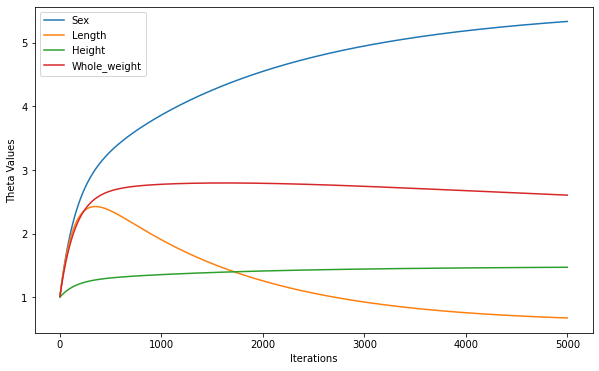

In [25]:
# shape of theta_vec is (1, num_features+1, itr)
theta_vec = theta_vec.T
plt.figure(figsize=(10,6))
plt.plot(theta_vec[0][0],label='Sex')
plt.plot(theta_vec[0][1],label='Length')
plt.plot(theta_vec[0][3],label='Height')
plt.plot(theta_vec[0][4],label='Whole_weight')
plt.xlabel('Iterations')
plt.ylabel('Theta Values')
plt.legend()
plt.show()

In [26]:
def predict_val(input, theta):
  return np.dot(input, theta)

def calc_error(y, y_pred):
  y = np.array(y)
  y = np.reshape(y, (y.shape[0], 1))
  num_train_samples = np.shape(y)[0]
  loss = y - y_pred
  return math.sqrt((1/num_train_samples) * np.sum(loss ** 2))

y_pred = predict_val(X_test, theta)
test_rmse = calc_error(Y_test, y_pred)
print('Train RMSE:')
print(train_rmse)
print('Test RMSE:')
print(test_rmse)

Train RMSE:
2.631090269245726
Test RMSE:
2.789231153613648


# Regularisation using Ridge and Lasso

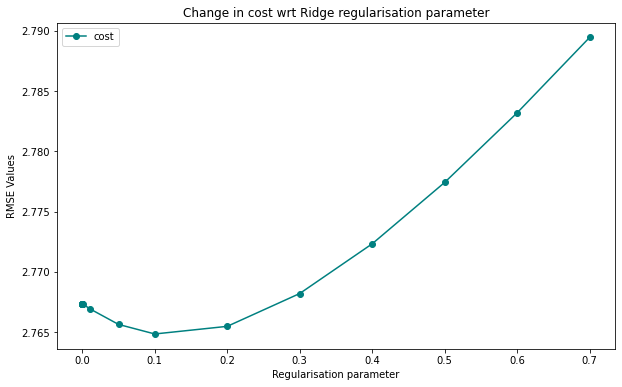

Model parameters: [[-4.71185409  0.47298576  4.25924138  4.03597045  1.12657027]]


In [88]:
# Ridge regression

reg_cost_vec = []   # cost values for each alpha
alpha_vec = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.05, 1e-1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7] # learning rates
for alpha in alpha_vec:
    ridge_reg = linear_model.Ridge(alpha, normalize=True)
    ridge_reg.fit(X_train, Y_train)
    y_pred = ridge_reg.predict(X_test)
    rreg_test_rmse = math.sqrt(mean_squared_error(Y_test, y_pred))
    reg_cost_vec.append(rreg_test_rmse)

plt.figure(figsize=(10, 6))
plt.plot(alpha_vec, reg_cost_vec, label='cost', marker = 'o', color = 'teal')
plt.title('Change in cost wrt Ridge regularisation parameter')
plt.xlabel('Regularisation parameter')
plt.ylabel('RMSE Values')
plt.legend()
plt.show()

print('Model parameters:', ridge_reg.coef_)

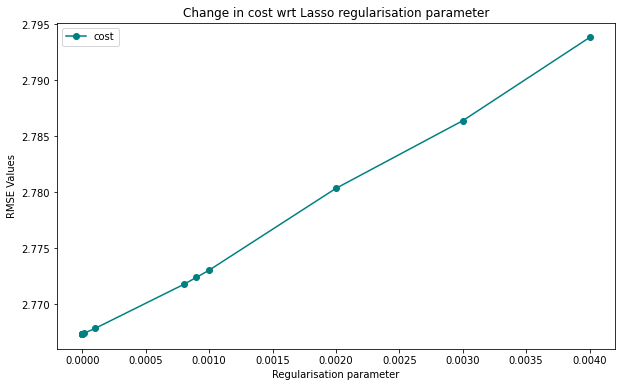

Model parameters: [-0.          0.41270811  5.84644868  0.          1.42080804]


In [104]:
# Lasso regression

reg_cost_vec = [] # cost values for each alpha
alpha_vec = [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 8e-4, 9e-4, 1e-3, 2e-3, 3e-3, 4e-3] # learning rates
for alpha in alpha_vec:
    lasso_reg = linear_model.Lasso(alpha, normalize=True)
    lasso_reg.fit(X_train, Y_train)
    y_pred = lasso_reg.predict(X_test)
    lreg_test_rmse = math.sqrt(mean_squared_error(Y_test, y_pred))

    reg_cost_vec.append(lreg_test_rmse)

plt.figure(figsize=(10,6))
plt.plot(alpha_vec, reg_cost_vec, label='cost', marker = 'o', color = 'teal')
plt.title('Change in cost wrt Lasso regularisation parameter')
plt.xlabel('Regularisation parameter')
plt.ylabel('RMSE Values')
plt.legend()
plt.show()

print('Model parameters:', lasso_reg.coef_)

Grid Search

In [105]:
# Ridge regression
alpha_vec = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.05, 1e-1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
parameters = {'alpha':alpha_vec}
ridge_reg = linear_model.Ridge(0.001, normalize=True)
ridge_gs = GridSearchCV(ridge_reg, parameters, scoring='neg_root_mean_squared_error', cv=5)
ridge_gs.fit(X_train, Y_train)

print(ridge_gs.best_estimator_)
print(ridge_gs.best_params_)
print(ridge_gs.score(X_test, Y_test))
print('Best parameters for ridge:', ridge_gs.best_params_)

print()

# Lasso regression
alpha_vec = [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 8e-4, 9e-4, 1e-3, 2e-3, 3e-3, 4e-3]
parameters = {'alpha':alpha_vec}
lasso_reg = linear_model.Lasso(0.001, normalize=True)
lasso_gs = GridSearchCV(lasso_reg, parameters, scoring='neg_root_mean_squared_error', cv=5)
lasso_gs.fit(X_train, Y_train)

print(lasso_gs.best_estimator_)
print(lasso_gs.best_params_)
print(lasso_gs.score(X_test, Y_test))

print('Best parameters for lasso:', lasso_gs.best_params_)

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None, normalize=True,
      random_state=None, solver='auto', tol=0.001)
{'alpha': 0.5}
-2.777415792244778
Best parameters for ridge: {'alpha': 0.5}

Lasso(alpha=0.004, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=True, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
{'alpha': 0.004}
-2.79382357061922
Best parameters for lasso: {'alpha': 0.004}


# Linear Regression using sklearn

In [64]:
linreg = linear_model.LinearRegression()
linreg.fit(X_train, Y_train)
y_pred = linreg.predict(X_test)

# linear regression RMSE
print(metrics.mean_squared_error(Y_test, y_pred, squared=False))

2.767369074020373


In [65]:
# linear regression coefficients
print(linreg.coef_)

[[-8.95631986  0.57539612  6.66993753  1.63829538  1.46317463]]


In [66]:
# linear regression intercept
print(linreg.intercept_)

[13.38514097]
